# Mildly fat tails

## Fat tails vs thin tails

Although many real-world data follow [fat-tailed](https://en.wikipedia.org/wiki/Fat-tailed_distribution#Fat_tails_and_risk_estimate_distortions) distributions, most financial modelling work is done while wrongly assuming "thin-tailed" distributions. A very popular thin-tailed distribution is the [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution).

A distribution is thin-tailed if the most relevant data are the data that cluster in the "middle" of the distribution. On the other hand, a distribution is fat-tailed if the most relevant data are far away from the "middle", in the so-called "tails".

We would like to "fatten" the tails of a normal distribution to emulate fat-tailed behaviour and study fat tails. The tails can be fattened by increasing the normal distribution's "standard deviation", $\sigma$. The higher the $\sigma$, the more spread out the data belonging to the normal distribution, and the more spread out the data, the more relevant data there are in the tails.

In [27]:
# start by importing all the necessary tools

import matplotlib.pyplot as plt
import matplotlib.pylab  as pylab  

import numpy as np
import scipy.stats

from mpl_toolkits.mplot3d import Axes3D

params = {
    "legend.fontsize" : "xx-large",
    "axes.labelsize"  : "xx-large",
    "axes.titlesize"  : "xx-large",
    "xtick.labelsize" : "xx-large",
    "ytick.labelsize" : "xx-large"
}

pylab.rcParams.update(params)

## Stochastisizing $\sigma$

We vary $\sigma$ by "stochastisizing" it. We begin stochastisizing $\sigma$ in the function `two_norms_two_stds` by picking randomly between $\sigma^+$ and $\sigma^-$ where $\sigma^+ = \sqrt{1 + a}$ and $\sigma^- = \sqrt{1 - a}$, $0 \leq a \lt 1$.

In the plots that will follow, we can see how the higher the $\sigma$ the more the spread of the data.

array([ 0.32029355, -1.20203235,  0.52017406, ...,  1.11222824,
        1.08466632, -1.61293669])

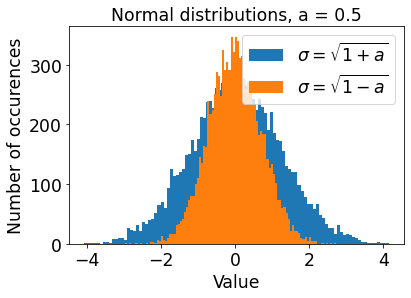

In [28]:
def two_norms_two_stds(
        num_samples,
        a,
        plot=False
    ):
        """
        In this function, we are picking from two normal distributions instead of just one.
        
        X ~ N(mu, sigma) means: 
        "a random variable X follows a normal distribution with a mean of mu and a STD of sigma".
        
        Consider: X ~ i * N( 0, sqrt(1 + a) ) + (1 - i) * N( 0, sqrt(1 - a) ), 0 < a <= 1.
        
        Furthermore, there is a 50% probability that i = 0 and a 50% probability that i = 1.
        
        These probabilities essentially mean that X is a random variable that
        follows a normal distribution with:
        
        - mean 0 and STD sqrt(1 + a) half of the time and
        - mean 0 and STD sqrt(1 - a) the other half of the time.
        
        As the STD varies, we have essentially stochastised the STD.
        """
        
        mean = 0
        
        sigma_plus_a  = np.sqrt(1 + a)
        sigma_minus_a = np.sqrt(1 - a)
        
        X_plus_a  = scipy.stats.norm.rvs(loc=mean, scale=sigma_plus_a,  size=num_samples)
        X_minus_a = scipy.stats.norm.rvs(loc=mean, scale=sigma_minus_a, size=num_samples)
        
        prob = 0.5
        
        i = scipy.stats.binom.rvs(1, prob, size=num_samples) # i is 1 with probability = prob
        
        X = i * X_plus_a + (1 - i) * X_minus_a
        
        if plot:
            plt.hist(X_plus_a,  bins=100, label="$\sigma=\sqrt{1+a}$")
            plt.hist(X_minus_a, bins=100, label="$\sigma=\sqrt{1-a}$")
            plt.legend()
            plt.title("Normal distributions, a = " + str(a))
            plt.xlabel("Value")
            plt.ylabel("Number of occurences")
        
        return X
    
two_norms_two_stds(10000, 0.5, True)

## Sampling from fat tails

Having stochastisized $\sigma$, we can randomly sample from the distribution. The random sampling is achieved In `two_norms_two_stds` by sampling half of the time from the normal distribution with $\sigma=\sigma^+$ that has fatter tails. The other half of the time we sample from the distribution with $\sigma=\sigma^-$.

The sampling is performed for an array of increasing $a$. For each $a$, we compute the kurtosis, which is the fourth "[moment](https://en.wikipedia.org/wiki/Moment_(mathematics)#Significance_of_the_moments)" of the distribution. For reference, the $n^{th}$ moment $\mu_n$ of a function $f(x)$ can be computed using the integral

$\mu_n = \int_{-\infty}^{\infty} (x - c)^n f(x) \, dx.$

However, we do not need this integral as we can use in-built `scipy.stats` functions. Using these functions, we plot the kurtosis against $a$ in the function `plot_kurtosis_two_stds`. This function will show that the higher the $a$ i.e. the more fat tailed the distribution, the higher the kurtosis.

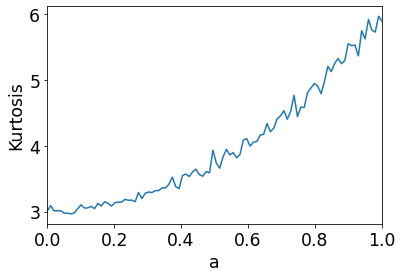

In [29]:
def plot_kurtosis_two_stds():
    """
    The kurtosis is the fourth moment of a distribution.
    
    With the "two norms" distribution, the kurtosis is a function of "a" as 3(a**2 + 1).
    
    Therefore, as 0 <= a < 1, the kurtosis should vary between 3 and 6.
    
    The higher the value of a, the more power law-like the behaviour of the distribution
    
    For a = 0, we are essentially sampling from a single normal distribution.
    
    For a = 0.999, we are sampling on one hand from a normal distribution with a very small STD,
    and on the other hand from a normal distribution a very high STD.
    
    The high STD will lead to jumps in the samples that increase the kurtosis.
    
    """
    num_a = 100
    
    a = np.linspace(0, 1, num_a)
    
    kurtosis = [scipy.stats.kurtosis(two_norms_two_stds(10000, a_), fisher=False) for a_ in a]
    
    plt.plot(a, kurtosis)
    plt.xlim(0, 1)
    plt.ylabel("Kurtosis")
    plt.xlabel('a')
    
plot_kurtosis_two_stds()

## Moments of fat tails

The intuition is that the higher the kurtosis, the more fat-tailed the distribution.

Later, we will see that this intuition can be generalised: the more fat-tailed the distribution, the more likely that the moments of the distributions are infinity or undefined. Furthermore, the higher the moment, the more likely that it is undefined.

In `two_norms_skewed_stds` we further stochastisize $\sigma$ such that we get even higher kurtoses.

In [30]:
def two_norms_skewed_stds(
        num_samples,
        a,
        p,
        plot=False
    ):
        """
        In this function, we are again picking from two normal distributions instead of only one.
        
        The STDs of the distributions are decided differently.
        
        Namely, the STDs depend on some probability "p".
        
        Furthermore, we use p to decide how we sample from the two distributions,
        instead of sampling from each distribution equally.
        
        For example, for p = 1/100 we sample from one distribution 1 time out of a 100 times,
        and sample from the other distribution 99 times out of a 100 times.
        """
        
        b = - a * p / (1 - p)
        
        mean = 0
        
        sigma_a = np.sqrt(1 + a)
        sigma_b = np.sqrt(1 + b)
        
        X_a = scipy.stats.norm.rvs(loc=mean, scale=sigma_a, size=num_samples)
        X_b = scipy.stats.norm.rvs(loc=mean, scale=sigma_b, size=num_samples)
        
        # i is 1 with probability = p
        # for example, p = 1 / 100 means i = 1 for 1 out of 100 times
        i = scipy.stats.binom.rvs(1, p, size=num_samples)
        
        # for p = 1 / 100, we are essentially picking from X_a 1 out of 100 times, otherwise
        # picking from X_b the rest of the time
        X = i * X_a + (1 - i) * X_b
        
        if plot:
            plt.plot(X)
            plt.title("Fat tails?")
            plt.xlabel("Value")
            plt.ylabel("Sample")
            plt.xlim(0, num_samples)
        
        return X

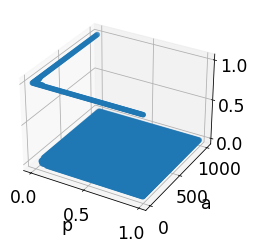

In [31]:
def plot_valid_b_std():
    """
    Two parameters go into calculating the STD of one of the distributions in
    two_norms_skewed_stds, a and p.
    
    This function shows the valid combinations of a and p for calculating the STD.
    
    When calculating the STD, a very low p, e.g. 0 <= p < 0.01, is needed to be 
    able to use a wide range of a, e.g. 0 <= a < 1000.
    
    """
    
    N = 100
    
    p = np.linspace(0, 0.99, N)
    a = np.linspace(0, 999, N)
    
    P, A = np.meshgrid(p, a)
    
    B = - A * P / (1 - P)
    
    valid_B = (1 + B) > 0
    
    fig, ax = plt.subplots( subplot_kw={"projection" : "3d"} )
    
    ax.scatter(P, A, valid_B)
    plt.setp(ax, xlabel='p', ylabel='a')
    
plot_valid_b_std()

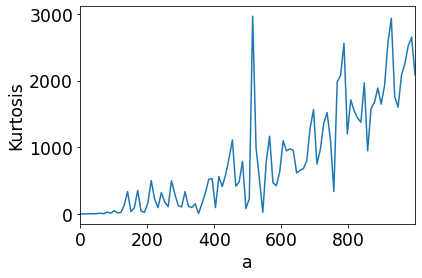

In [34]:
def plot_kurtosis_skewed_stds():
    num_a = 100
    
    a = np.linspace(0, 999, num_a)
    
    kurtosis = [scipy.stats.kurtosis(two_norms_skewed_stds(10_000, a_, 0.001), fisher=False) for a_ in a]
    
    plt.plot(a, kurtosis)
    plt.xlim(0, 999)
    plt.ylabel("Kurtosis")
    plt.xlabel('a')
    
plot_kurtosis_skewed_stds()

## Fluctuating kurtoses

It is noted that the kurtosis generally increases as $a$ increases, but there are also seemingly random spikes in the kurtosis. These spikes give us another intuition about fat-tailed distributions: we cannot necessarily tell from sampling alone that we are working with a fat-tailed distribution.

The function `plot_skewed_stds` should hopefully also show this intuition. This function will show that while the majority of our samples appear to fall within a normal distribution, we will unexpectedly get huge jumps, i.e. black swans.

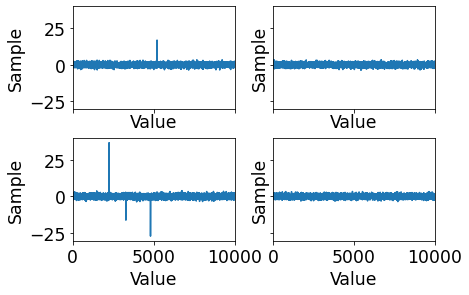

In [35]:
def plot_skewed_stds():
    fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
    
    num_samples = 10_000
    
    fig.tight_layout()
    
    for i, ax in enumerate(axs.flat):
        ax.plot(two_norms_skewed_stds(num_samples=num_samples, a=500, p=0.0001))
        plt.setp( ax, xlabel="Value", ylabel="Sample", xlim=(0, num_samples) )
        
plot_skewed_stds()

## Where do the fat tails begin?

Depending on how we stochastize the scale of a distribution, e.g. the $\sigma$ in the the case of the normal distribution, we get higher kurtosis, which is indicative of fat-tailed behaviour.

The kurtosis of distributions can be controlled by stochastisizing the scale of those distributions. The stochasticization can be done by making the scale follow some other kind of distribution. For example, the scale can be made to vary as per the:

- lognormal
- normal
- gamma
- Pareto

distributions. When the scale of a distribution varies, the tails of the distribution change shape in a certain way. By observing how the shape changes, we can identify the where the tails start. Simply, the tails begin where the distribution is convex with respect to its stochastisized scale.